In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
import re


In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import pandas as pd

# Load the CSV from Google Drive
file_path = '/content/drive/MyDrive/complaints_processed.csv'
df = pd.read_csv(file_path)

# Check the first few rows
df.head()


,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [24]:
df = pd.read_csv('/content/drive/MyDrive/complaints_processed.csv')
print(df.shape)
print(df.head())


(162421, 3)
   Unnamed: 0           product  \
0           0       credit_card   
1           1       credit_card   
2           2    retail_banking   
3           3  credit_reporting   
4           4  credit_reporting   

                                           narrative  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...  


In [25]:
df = df[['product', 'narrative']].dropna()


(162411, 3)
product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64


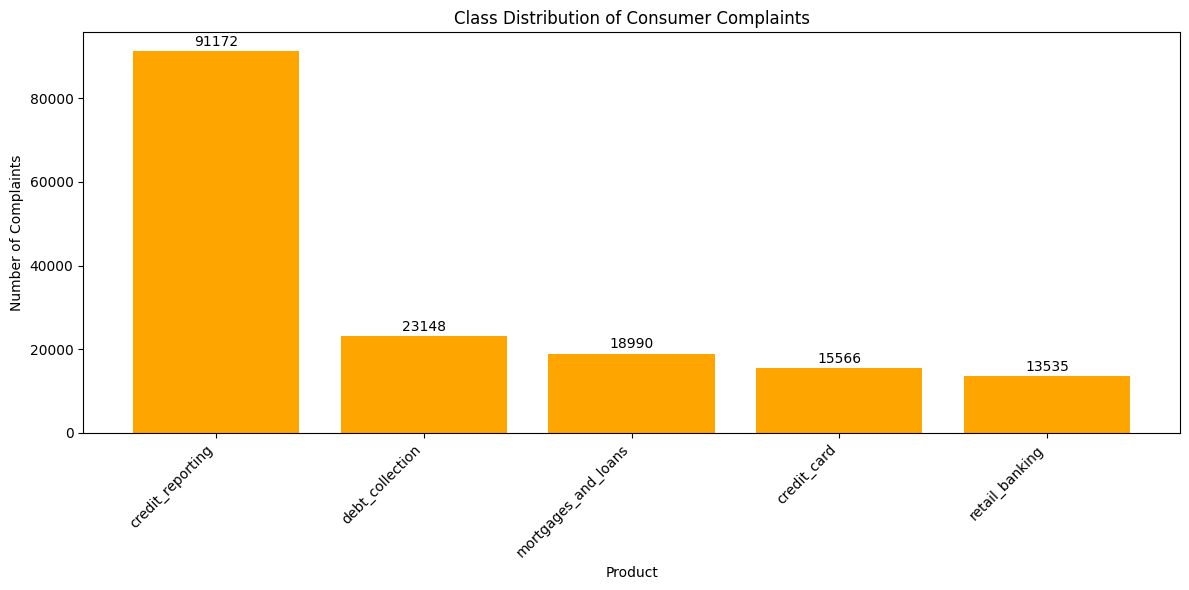

Class distribution bar plot generated by Srinithy on 28-Sep-2025 14:39:29.


In [44]:
import matplotlib.pyplot as plt
from datetime import datetime

# Check shape and counts
print(df.shape)
print(df['product'].value_counts())

# Plot product distribution
class_counts = df['product'].value_counts()

plt.figure(figsize=(12,6))
bars = plt.bar(class_counts.index, class_counts.values, color='orange')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.title('Class Distribution of Consumer Complaints')

# Add counts above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 500, str(height),  # offset by 500
             ha='center', va='bottom')

plt.tight_layout()

# Save plot with name and timestamp
current_time = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")  # for filename
readable_time = datetime.now().strftime("%d-%b-%Y %H:%M:%S")  # for caption
filename = f"class_distribution_Srinithy_{current_time}.png"
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Caption for README
caption = f"Class distribution bar plot generated by Srinithy on {readable_time}."
print(caption)


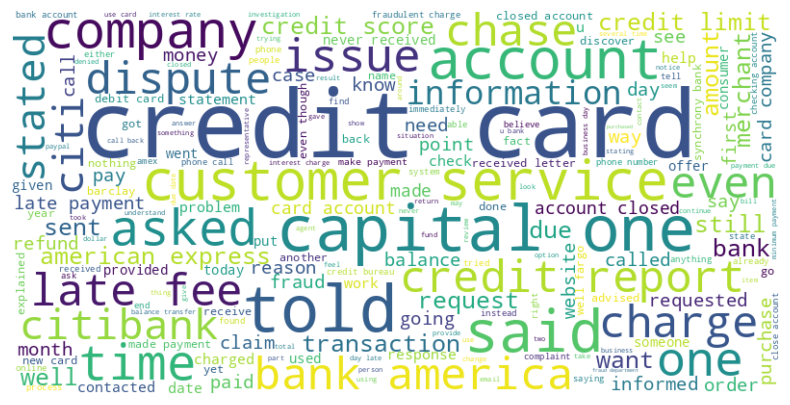

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df[df['product']=='credit_card']['narrative'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [15]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation/numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['complaint_text'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,product,complaint_text,category,clean_text


In [28]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['narrative'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [29]:
df[['narrative', 'clean_text']].head(10)


,narrative,clean_text
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...
5,payment history missing credit report made mis...,payment history missing credit report made mis...
6,va date complaint experian credit bureau invol...,va date complaint experian credit bureau invol...
7,account reported abbreviated name full name se...,account reported abbreviated name full name se...
8,account reported abbreviated name full name se...,account reported abbreviated name full name se...
9,usdoexxxx account reported abbreviated name fu...,usdoexxxx account reported abbreviated name fu...


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigrams + bigrams

# Fit on cleaned text and transform
X = tfidf.fit_transform(df['clean_text'])


In [35]:
from sklearn.preprocessing import LabelEncoder

y = df['product']  # target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # numeric labels for each product


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression
lr_model = LogisticRegression(max_iter=200, multi_class='ovr')
lr_model.fit(X_train, y_train)

# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


MultinomialNB()

In [39]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

# Logistic Regression
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Naive Bayes
print("=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))


=== Logistic Regression ===
Accuracy: 0.8747344764953976
                     precision    recall  f1-score   support

        credit_card       0.80      0.78      0.79      3113
   credit_reporting       0.90      0.94      0.92     18235
    debt_collection       0.82      0.73      0.77      4630
mortgages_and_loans       0.86      0.83      0.84      3798
     retail_banking       0.87      0.88      0.87      2707

           accuracy                           0.87     32483
          macro avg       0.85      0.83      0.84     32483
       weighted avg       0.87      0.87      0.87     32483

=== Naive Bayes ===
Accuracy: 0.8315426530800727
                     precision    recall  f1-score   support

        credit_card       0.69      0.76      0.72      3113
   credit_reporting       0.91      0.87      0.89     18235
    debt_collection       0.76      0.66      0.71      4630
mortgages_and_loans       0.71      0.88      0.79      3798
     retail_banking       0.81      

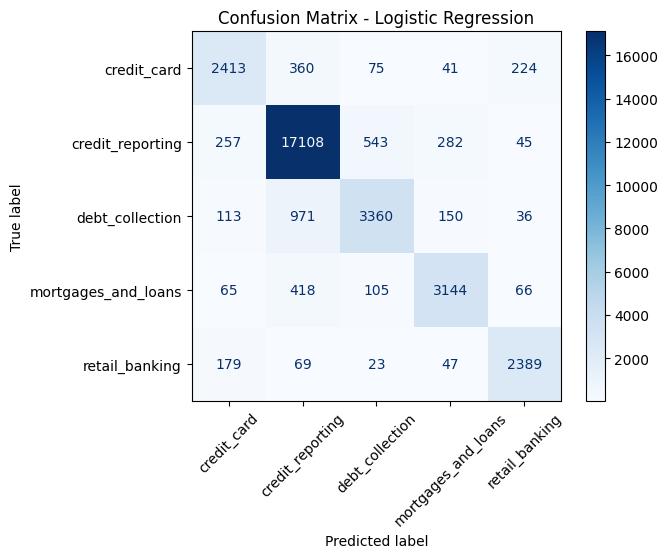

Confusion matrix generated by Srinithy on 28-Sep-2025 14:38:27.


In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

# Assume y_test and y_pred_lr are defined
# And le = LabelEncoder() used for categories

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Current date and time
current_time = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")  # for filename
readable_time = datetime.now().strftime("%d-%b-%Y %H:%M:%S")  # for caption

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")  # or your model name

# Save plot with your name and timestamp
filename = f"confusion_matrix_lr_Srinithy_{current_time}.png"
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Caption for README
caption = f"Confusion matrix generated by Srinithy on {readable_time}."
print(caption)


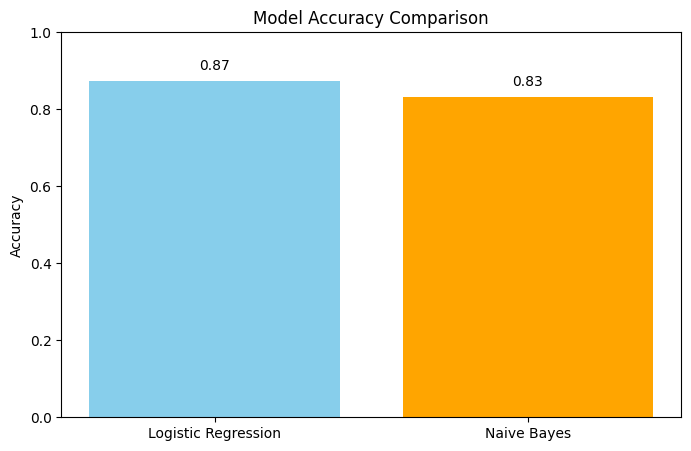

Accuracy comparison of Logistic Regression and Naive Bayes generated by Srinithy on 28-Sep-2025 14:42:06.


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

# Accuracy
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_nb = accuracy_score(y_test, y_pred_nb)

# F1-scores (macro)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
f1_nb = f1_score(y_test, y_pred_nb, average='macro')

# Bar plot for Accuracy
models = ['Logistic Regression', 'Naive Bayes']
accuracy = [acc_lr, acc_nb]
f1_scores = [f1_lr, f1_nb]

plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracy, color=['skyblue','orange'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Add accuracy text above bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{accuracy[i]:.2f}",
             ha='center', va='bottom')

# Save plot with name and timestamp
from datetime import datetime
current_time = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")
readable_time = datetime.now().strftime("%d-%b-%Y %H:%M:%S")
filename = f"model_accuracy_comparison_Srinithy_{current_time}.png"
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Caption for README
caption = f"Accuracy comparison of Logistic Regression and Naive Bayes generated by Srinithy on {readable_time}."
print(caption)


In [41]:
new_complaints = [
    "Payment not credited to my account",
    "Received wrong credit card statement",
    "Loan approval delayed"
]

# Clean new complaints
new_clean = [clean_text(text) for text in new_complaints]

# Transform with TF-IDF
new_vec = tfidf.transform(new_clean)

# Predict using Logistic Regression
pred_labels = lr_model.predict(new_vec)
pred_products = le.inverse_transform(pred_labels)

print("Predicted products for new complaints:", pred_products)


Predicted products for new complaints: ['mortgages_and_loans' 'credit_card' 'mortgages_and_loans']
